<a href="https://colab.research.google.com/github/jaygo-kr/brunch/blob/master/03_02_nlp_and_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 드라마 대본 자연어 태깅 및 EDA

> 들여쓴 블록


* 이전 노트에서 정제한 대본 자료의 문장들을 테깅 해보고 데이터 분석을 통해 데터를 둘러보기
1. 정제한 대본 파일 불러오기
2. 한국어 태깅 시키기
3. 명사 워드클라우드 그리기
4. 자연어 통계분석

In [38]:
import os
import numpy as np
import pandas as pd
from google.colab import files, drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
os.listdir('./gdrive/My Drive/share/suwon study/script/JAY완료/')

['W+제11회+대본.csv',
 'W+제12회+대본.csv',
 'W+제13회+대본.csv',
 'W+제15회+대본.csv',
 'W+제4회+대본.csv',
 'W+제1회+대본.csv',
 'W+제14회+대본.csv',
 'W+제3회+대본.csv',
 'W+제16회+대본.csv',
 'W+제2회+대본.csv',
 'W+제5회+대본.csv',
 'W+제7회+대본.csv',
 'W+제6회+대본.csv',
 'W+제9회+대본.csv',
 'W+제8회+대본.csv',
 'W+제10회+대본.csv',
 'W+제1회+대본.gsheet',
 'text to csv.ipynb의 사본']

In [0]:
DATA_PATH = './gdrive/My Drive/share/suwon study/script/JAY완료/'

## 데이터 불러오기

In [0]:
script_df = pd.read_csv(DATA_PATH + 'W+제1회+대본.csv')

In [42]:
script_df.head()

,act,content
0,씬/1,아테네 올림픽 자료화면 인서트 \n
1,지문,자막 – 2004년 8월. 아테네 올림픽\n한국 국가대표 경기 생중계 자료화면.\n...
2,씬/2,"방송 스튜디오 (과거, 밤)\n"
3,지문,올림픽 중계 스튜디오. 아테네 올림픽 엠블럼과 마스코트를 배경으로 남자 MC가 진행...
4,MC,"네, 잠시 종목을 바꿔보겠습니다. 지금 사격 경기장에서는 50미터 권총 남자 결선이..."


## 문장 태깅하기
* content 전체에 대하여 명사로 태깅해보자

In [0]:
# 한글 태깅을 위한 패키지 설치
! pip install konlpy

In [0]:
from konlpy.tag import Komoran, Twitter, Hannanum

In [45]:
Komoran = Komoran()
Twitter = Twitter()
Hannanum = Hannanum()

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [0]:
# 태그 전 대본 대사 마지막에 있는 개행문자 제거
content = script_df.content.map(lambda x: x.rstrip('\n'))

In [0]:
# 태깅 입력을 위해 하나의 문장으로 연결
content_tie = content.str.cat(sep=' ')

In [0]:
# 명사 태깅을 위한 클래스들 비교를 위해 3가지 클래스 사용
content_nouns_ha = Hannanum.nouns(content_tie)
content_nouns_tw = Twitter.nouns(content_tie)
content_nouns_ko = Komoran.nouns(content_tie)

In [0]:
content_nouns_ha_pd = pd.Series(content_nouns_ha)
content_nouns_tw_pd = pd.Series(content_nouns_tw)
content_nouns_ko_pd = pd.Series(content_nouns_ko)

In [50]:
# 태깅 클래스마다 차이가 있다.
content_nouns_compare = pd.DataFrame()
content_nouns_compare = pd.concat([content_nouns_compare, content_nouns_ko_pd.value_counts()[:30].reset_index()], axis=1)
content_nouns_compare = pd.concat([content_nouns_compare, content_nouns_tw_pd.value_counts()[:30].reset_index()], axis=1)
content_nouns_compare = pd.concat([content_nouns_compare, content_nouns_ha_pd.value_counts()[:30].reset_index()], axis=1)
content_nouns_compare.columns = ['Komoran','count','Twitter','count','Hannanum','count']
content_nouns_compare.head(10)

,Komoran,count,Twitter,count,Hannanum,count
0,강철,137,강철,137,강철,116
1,연주,109,연주,103,연주,101
2,!!,48,안,40,것,65
3,말,40,거,40,수,44
4,거,38,말,38,나,38
5,선수,35,선수,36,남자,34
6,성,35,남자,34,말,30
7,남자,34,이,34,밤,26
8,중,33,그,34,낮,25
9,수,32,왜,29,뭐,25


In [51]:
# 태거들을 합하여 평균적인 결과물을 도출
content_nouns_mix = pd.concat([content_nouns_ha_pd,content_nouns_tw_pd,content_nouns_ko_pd])
content_nouns_mix_rank = content_nouns_mix.value_counts()[:30].reset_index()
content_nouns_mix_rank.columns = ['Tagger Mix','count']
content_nouns_mix_rank['count'] = content_nouns_mix_rank['count']//3
content_nouns_mix_rank.head(10)

,Tagger Mix,count
0,강철,130
1,연주,104
2,말,36
3,남자,34
4,것,34
5,거,29
6,수,28
7,밤,26
8,소리,25
9,핸드폰,25


In [52]:
# 태깅 클래스 사용에도 불구하고 '것, 거, 수' 등 명사로 활용키 어려운 것들은 제거하자
print("before remove {}".format(len(content_nouns_mix)))
remove_list = ['것','거','수','중','이','듯','안','뭐','앞','!!']
for n in remove_list:
  content_nouns_mix.drop(content_nouns_mix[content_nouns_mix.values == n].index, inplace=True)
print("before remove {}".format(len(content_nouns_mix)))

before remove 12004
before remove 10199


In [53]:
# 쓸만한 명사들의 순위가 나왔다.
content_nouns_mix_rank = content_nouns_mix.value_counts()[:30].reset_index()
content_nouns_mix_rank.columns = ['Tagger Mix','count']
content_nouns_mix_rank['count'] = content_nouns_mix_rank['count']//3
content_nouns_mix_rank.head(10)

,Tagger Mix,count
0,강철,115
1,연주,92
2,말,32
3,남자,30
4,소리,23
5,밤,21
6,핸드폰,21
7,낮,21
8,아버지,20
9,선수,19


## 워드클라우드 그리기

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [0]:
# 워드클래스 패키지에 입력으로 사용하기 위하여 단어 : 등장횟수 를 사전형식으로 변환
content_rank_dict = {}
for noun, cnt in content_nouns_mix_rank.values:
  content_rank_dict[noun]=cnt

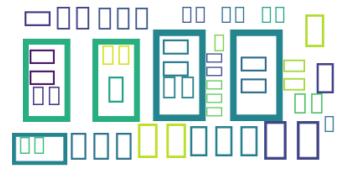

In [56]:
# 한글 출력시 에러 발생
wordcloud = WordCloud(background_color='white').generate_from_frequencies(content_rank_dict)
fig = plt.figure()
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

In [0]:
# 한글 폰트 설치
! apt-get install fonts-nanum*

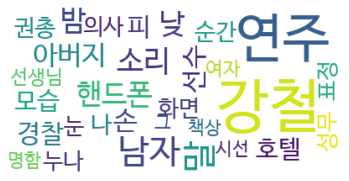

In [58]:
# 한글 폰트 문제 해결
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
wordcloud = WordCloud(font_path = font_path, background_color='white').generate_from_frequencies(content_rank_dict)
fig = plt.figure()
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

## 기초통계 수행
* 대사의 길이
* 등장인물별 대사의 비중
* 단어의 종류

In [0]:
script_df.content = script_df.content.map(lambda x: x.rstrip('\n'))

In [60]:
script_df

,act,content
0,씬/1,아테네 올림픽 자료화면 인서트
1,지문,자막 – 2004년 8월. 아테네 올림픽\n한국 국가대표 경기 생중계 자료화면.\n...
2,씬/2,"방송 스튜디오 (과거, 밤)"
3,지문,올림픽 중계 스튜디오. 아테네 올림픽 엠블럼과 마스코트를 배경으로 남자 MC가 진행...
4,MC,"네, 잠시 종목을 바꿔보겠습니다. 지금 사격 경기장에서는 50미터 권총 남자 결선이..."
...,...,...
574,지문,"연주, 못 알아듣자 답답해 전화를 끊어버리는.\n밖에서는 석범이 문 두드리며 ‘야 ..."
575,연주,(살아있는 사람에게 말 걸 듯) 왜 나를 찾아 당신...? 날 찾아서 어쩌려고...?
576,지문,"그림 속의 강철, 대답이 없고."
577,연주,왜 내가 당신 인생의 키가 되는데..?


In [0]:
# 대사에만 집중하기 위해 지문, 씬, C#등 제거 - '지문', '씬/.*', 'C#.*'
script_df_actor = script_df.drop(script_df[script_df['act'].str.find('지문') == 0].index)
script_df_actor = script_df_actor.drop(script_df_actor[script_df_actor['act'].str.find('씬/') == 0].index)
script_df_actor = script_df_actor.drop(script_df_actor[script_df_actor['act'].str.find('C#') == 0].index)

In [62]:
script_df_actor['act'].unique()

array(['MC', '캐스터', '해설', '가족들', '강철모', '강철부', '아이들', '앵커', '기자', '경감',
       '전문가', '현석', '강철', '철호', '자막', '연주', '석범', '김간호사', '간호사1', '간호사2',
       '박교수', '수봉', '선미/윤희', '성무', '연주/수봉', '선미', '  ', '일동', '웨이터',
       '의사1', '매니저', '구급대원', '윤희', '소희', '도윤'], dtype=object)

In [63]:
# 전처리 누락분 제거
script_df_actor[script_df_actor['act']=='  ']

,act,content
373,,"지글지글 고기 굽는 소리, 칼질하는 소리, 매운 연기에 라운지에서 들려오는 음악소리..."


In [0]:
script_df_actor = script_df_actor.drop(373)

### 등장인물의 종류

In [65]:
script_df_actor['act'].unique()

array(['MC', '캐스터', '해설', '가족들', '강철모', '강철부', '아이들', '앵커', '기자', '경감',
       '전문가', '현석', '강철', '철호', '자막', '연주', '석범', '김간호사', '간호사1', '간호사2',
       '박교수', '수봉', '선미/윤희', '성무', '연주/수봉', '선미', '일동', '웨이터', '의사1',
       '매니저', '구급대원', '윤희', '소희', '도윤'], dtype=object)

In [66]:
len(script_df_actor['act'].unique())

34

### 대사의 길이

In [0]:
import seaborn as sns

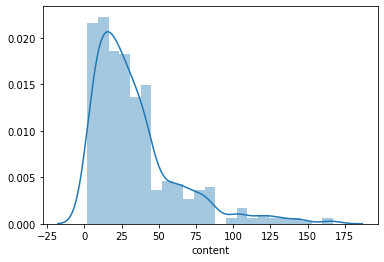

In [68]:
# 대사 길이의 분포를 보면 50자 이내의 대사가 대부분을 차지함을 알 수 있다.
sns.distplot(script_df_actor['content'].str.len())

In [69]:
print("summary of content length\n\
max : {}\n\
min : {}\n\
mean : {}\n\
std : {}\n".format(
            script_df_actor['content'].str.len().max(),
            script_df_actor['content'].str.len().min(),
            script_df_actor['content'].str.len().mean(),
            script_df_actor['content'].str.len().std()))

summary of content length
max : 167
min : 2
mean : 33.976133651551315
std : 29.041125819143765



## 인물별 대사의 비중

* 대사 횟수

In [70]:
# 연주가 혼자 다해먹나보다
script_df_actor['act'].value_counts().head(10)

연주     139
수봉      62
박교수     41
강철      28
캐스터     25
소희      19
웨이터     14
석범      13
해설      13
기자      13
Name: act, dtype: int64

* 대사 길이

In [0]:
script_df_actor['length'] = script_df_actor['content'].str.len()

In [72]:
# 역시 연주가 가장 말이 많다. 강철이라는 인물은 남자라 그런지 등장에 비해 대사 길이가 짧다.
script_df_actor.groupby('act').sum().sort_values(by='length', ascending=False).head(10)

,length
act,
연주,4046
수봉,1853
박교수,1454
캐스터,1379
기자,870
소희,665
강철,633
해설,558
매니저,456


### 어휘의 다양성

In [73]:
# 1편의 대본에 명자 2040개가 사용되었다.
len(content_nouns_mix.unique())

2040